In [222]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,BatchNormalization,Conv1D,Flatten,MaxPooling1D,LSTM
from keras.callbacks import EarlyStopping,ModelCheckpoint,TensorBoard
from keras.wrappers.scikit_learn import KerasRegressor
from keras.models import load_model
from sklearn.preprocessing import MinMaxScaler

plt.style.use('default')

In [223]:
def getHistoricalData(market: str='BTC-GBP', granularity: int=3600, iso8601start: str='', iso8601end: str='') -> pd.DataFrame:
  if iso8601start != '' and iso8601end == '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}')
  elif iso8601start != '' and iso8601end != '':
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}&start={iso8601start}&end={iso8601end}')
  else:
    resp = requests.get(f'https://api.pro.coinbase.com/products/{market}/candles?granularity={granularity}')

  df = pd.DataFrame.from_dict(resp.json())
  df.columns = [ 'epoch','low','high','open','close','volume' ]
  df['adj_close'] = df['close']

  tsidx = pd.DatetimeIndex(pd.to_datetime(df['epoch'], unit='s'), dtype='datetime64[ns]')
  df.set_index(tsidx, inplace=True)
  df = df.drop(columns=['epoch'])
  df.index.names = ['date']

  return df.iloc[::-1].reset_index()

In [224]:
def getHistoricalDataChained(market: str='BTC-GBP', granularity: int=3600, max_interations: int=1) -> pd.DataFrame:
  df1 = getHistoricalData(market, granularity)

  if max_interations == 1:
    return df1

  def getPreviousDateRange(df: pd.DataFrame=None) -> tuple:
    end_date = df['date'].min() - timedelta(seconds=(granularity / 60))
    new_start = df['date'].min() - timedelta(hours=300)
    return (str(new_start).replace(' ', 'T'), str(end_date).replace(' ', 'T'))

  iterations = 0
  result_df = pd.DataFrame()
  while iterations < (max_interations - 1):
    start_date, end_date = getPreviousDateRange(df1)
    df2 = getHistoricalData(market, granularity, start_date, end_date)
    result_df = pd.concat([df2, df1]).drop_duplicates()
    df1 = result_df
    iterations = iterations + 1

  if 'date'in result_df:
    result_df.sort_values(by=['date'], ascending=True, inplace=True)
        
  return result_df

In [225]:
df = getHistoricalDataChained(market, granularity, 30) # 1 year
df.shape

(8998, 7)

In [226]:
print (f'{df.shape[0] / 24} days of hourly trading data!')

374.9166666666667 days of hourly trading data!


In [227]:
df.head()

,date,low,high,open,close,volume,adj_close
0,2020-06-08 16:00:00,7631.05,7681.00,7656.12,7673.23,41.489209,7673.23
1,2020-06-08 17:00:00,7655.33,7690.97,7673.22,7670.00,31.664561,7670.00
2,2020-06-08 18:00:00,7641.03,7684.35,7668.60,7644.10,30.077688,7644.10
3,2020-06-08 19:00:00,7628.01,7657.23,7643.41,7630.88,40.625751,7630.88
4,2020-06-08 20:00:00,7630.00,7660.60,7630.82,7636.61,25.051888,7636.61


In [228]:
df['mv_avg_12'] = df['close'].rolling(window=12).mean().shift(1)
df['mv_avg_24'] = df['close'].rolling(window=24).mean().shift(1)
df.tail()

,date,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24
295,2021-06-18 11:00:00,27120.58,27350.00,27239.29,27241.52,50.641655,27241.52,27155.841667,27333.772917
296,2021-06-18 12:00:00,26925.08,27320.00,27250.87,27010.87,65.896743,27010.87,27147.799167,27299.086667
297,2021-06-18 13:00:00,26750.00,27169.99,27022.71,26879.88,65.844682,26879.88,27144.220000,27264.213333
298,2021-06-18 14:00:00,26440.00,26950.00,26885.32,26550.00,128.069808,26550.00,27133.464167,27226.659167
299,2021-06-18 15:00:00,26370.00,26676.00,26549.99,26380.95,54.470902,26380.95,27085.130833,27169.742500


In [229]:
df['rapp'] = df['close'].shift(-1).divide(df['close'])
df['next_close'] = df['close'].shift(-1)
df.head()

,date,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24,rapp,next_close
0,2020-06-08 16:00:00,7631.05,7681.00,7656.12,7673.23,41.489209,7673.23,NaN,NaN,0.999579,7670.00
1,2020-06-08 17:00:00,7655.33,7690.97,7673.22,7670.00,31.664561,7670.00,NaN,NaN,0.996623,7644.10
2,2020-06-08 18:00:00,7641.03,7684.35,7668.60,7644.10,30.077688,7644.10,NaN,NaN,0.998271,7630.88
3,2020-06-08 19:00:00,7628.01,7657.23,7643.41,7630.88,40.625751,7630.88,NaN,NaN,1.000751,7636.61
4,2020-06-08 20:00:00,7630.00,7660.60,7630.82,7636.61,25.051888,7636.61,NaN,NaN,1.002311,7654.26


In [230]:
df.index = df['date']
df.drop(columns=['date'], inplace=True)
df.head()

,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24,rapp,next_close
date,,,,,,,,,,
2020-06-08 16:00:00,7631.05,7681.00,7656.12,7673.23,41.489209,7673.23,NaN,NaN,0.999579,7670.00
2020-06-08 17:00:00,7655.33,7690.97,7673.22,7670.00,31.664561,7670.00,NaN,NaN,0.996623,7644.10
2020-06-08 18:00:00,7641.03,7684.35,7668.60,7644.10,30.077688,7644.10,NaN,NaN,0.998271,7630.88
2020-06-08 19:00:00,7628.01,7657.23,7643.41,7630.88,40.625751,7630.88,NaN,NaN,1.000751,7636.61
2020-06-08 20:00:00,7630.00,7660.60,7630.82,7636.61,25.051888,7636.61,NaN,NaN,1.002311,7654.26


In [231]:
df.dropna(inplace=True)
df.tail()

,low,high,open,close,volume,adj_close,mv_avg_12,mv_avg_24,rapp,next_close
date,,,,,,,,,,
2021-06-18 10:00:00,26700.00,27255.99,27000.15,27231.14,61.319477,27231.14,27156.989167,27372.667083,1.000381,27241.52
2021-06-18 11:00:00,27120.58,27350.00,27239.29,27241.52,50.641655,27241.52,27155.841667,27333.772917,0.991533,27010.87
2021-06-18 12:00:00,26925.08,27320.00,27250.87,27010.87,65.896743,27010.87,27147.799167,27299.086667,0.995150,26879.88
2021-06-18 13:00:00,26750.00,27169.99,27022.71,26879.88,65.844682,26879.88,27144.220000,27264.213333,0.987728,26550.00
2021-06-18 14:00:00,26440.00,26950.00,26885.32,26550.00,128.069808,26550.00,27133.464167,27226.659167,0.993633,26380.95


In [232]:
mtest = round(len(df) * 0.3)
train = df.iloc[:-mtest,:]
test = df.iloc[-mtest:,:]
train.shape, test.shape

((6281, 10), (2692, 10))

In [233]:
def yield_gross(df, v):
  prod=(v*df["rapp"]+1-v).prod()
  n_days=len(v)/24
  return (prod-1)*100,((prod**(1/n_days))-1)*100

In [234]:
def create_window(data, window_size=1):    
  data_s = data.copy()
  for i in range(window_size):
    data = pd.concat([data, data_s.shift(-(i+1))], axis=1)
        
  data.dropna(axis=0, inplace=True)
  return data

In [235]:
scaler = MinMaxScaler(feature_range=(0, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df[['low','high','open','close','volume','mv_avg_12','mv_avg_24','next_close']].values))
X_df_scaled = df_scaled[[0,1,2,3,4,5,6]]

In [236]:
window = 4
df_window = create_window(X_df_scaled, window)
X_df_window = np.reshape(df_window.values, (df_window.shape[0], window+1, len(X_df_scaled.columns)))
y_df_window = np.array(df_scaled[len(df_scaled.columns)-1][window:])

X_df_window.shape, y_df_window.shape

((8969, 5, 7), (8969,))

In [237]:
X_train = X_df_window[:-mtest-1,:,:]
X_test = X_df_window[-mtest-1:,:,:]
y_train = y_df_window[:-mtest-1]
y_test = y_df_window[-mtest-1:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6276, 5, 7), (2693, 5, 7), (6276,), (2693,))

In [238]:
def model_lstm(window,features):
  model = Sequential()
  model.add(LSTM(units=50, input_shape = (window, features), return_sequences=True))
  model.add(Dropout(0.5))
  model.add(LSTM(units=50, input_shape=(window, features), return_sequences=False))
  model.add(Dropout(0.5))
  model.add(Dense(units=50, kernel_initializer='uniform', activation='relu'))        
  model.add(Dense(1, kernel_initializer='uniform', activation='relu'))
  model.compile(loss='mse', optimizer='adam')
  return model

Epoch 1/100
262/262 [==============================] - 5s 8ms/step - loss: 2.9843e-04 - val_loss: 0.0231
Epoch 2/100
262/262 [==============================] - 1s 5ms/step - loss: 0.0205 - val_loss: 0.0260
Epoch 3/100
262/262 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0245
Epoch 4/100
262/262 [==============================] - 1s 5ms/step - loss: 4.5249e-04 - val_loss: 0.0258
Epoch 5/100
262/262 [==============================] - 1s 5ms/step - loss: 0.0190 - val_loss: 0.0220
Epoch 6/100
262/262 [==============================] - 1s 5ms/step - loss: 4.1395e-04 - val_loss: 0.0259
Epoch 7/100
262/262 [==============================] - 1s 5ms/step - loss: 4.3058e-04 - val_loss: 0.0287
Epoch 8/100
262/262 [==============================] - 1s 5ms/step - loss: 4.9077e-04 - val_loss: 0.0289
Epoch 9/100
262/262 [==============================] - 1s 5ms/step - loss: 4.8956e-04 - val_loss: 0.0298
Epoch 10/100
262/262 [==============================] - 1s 5ms/step

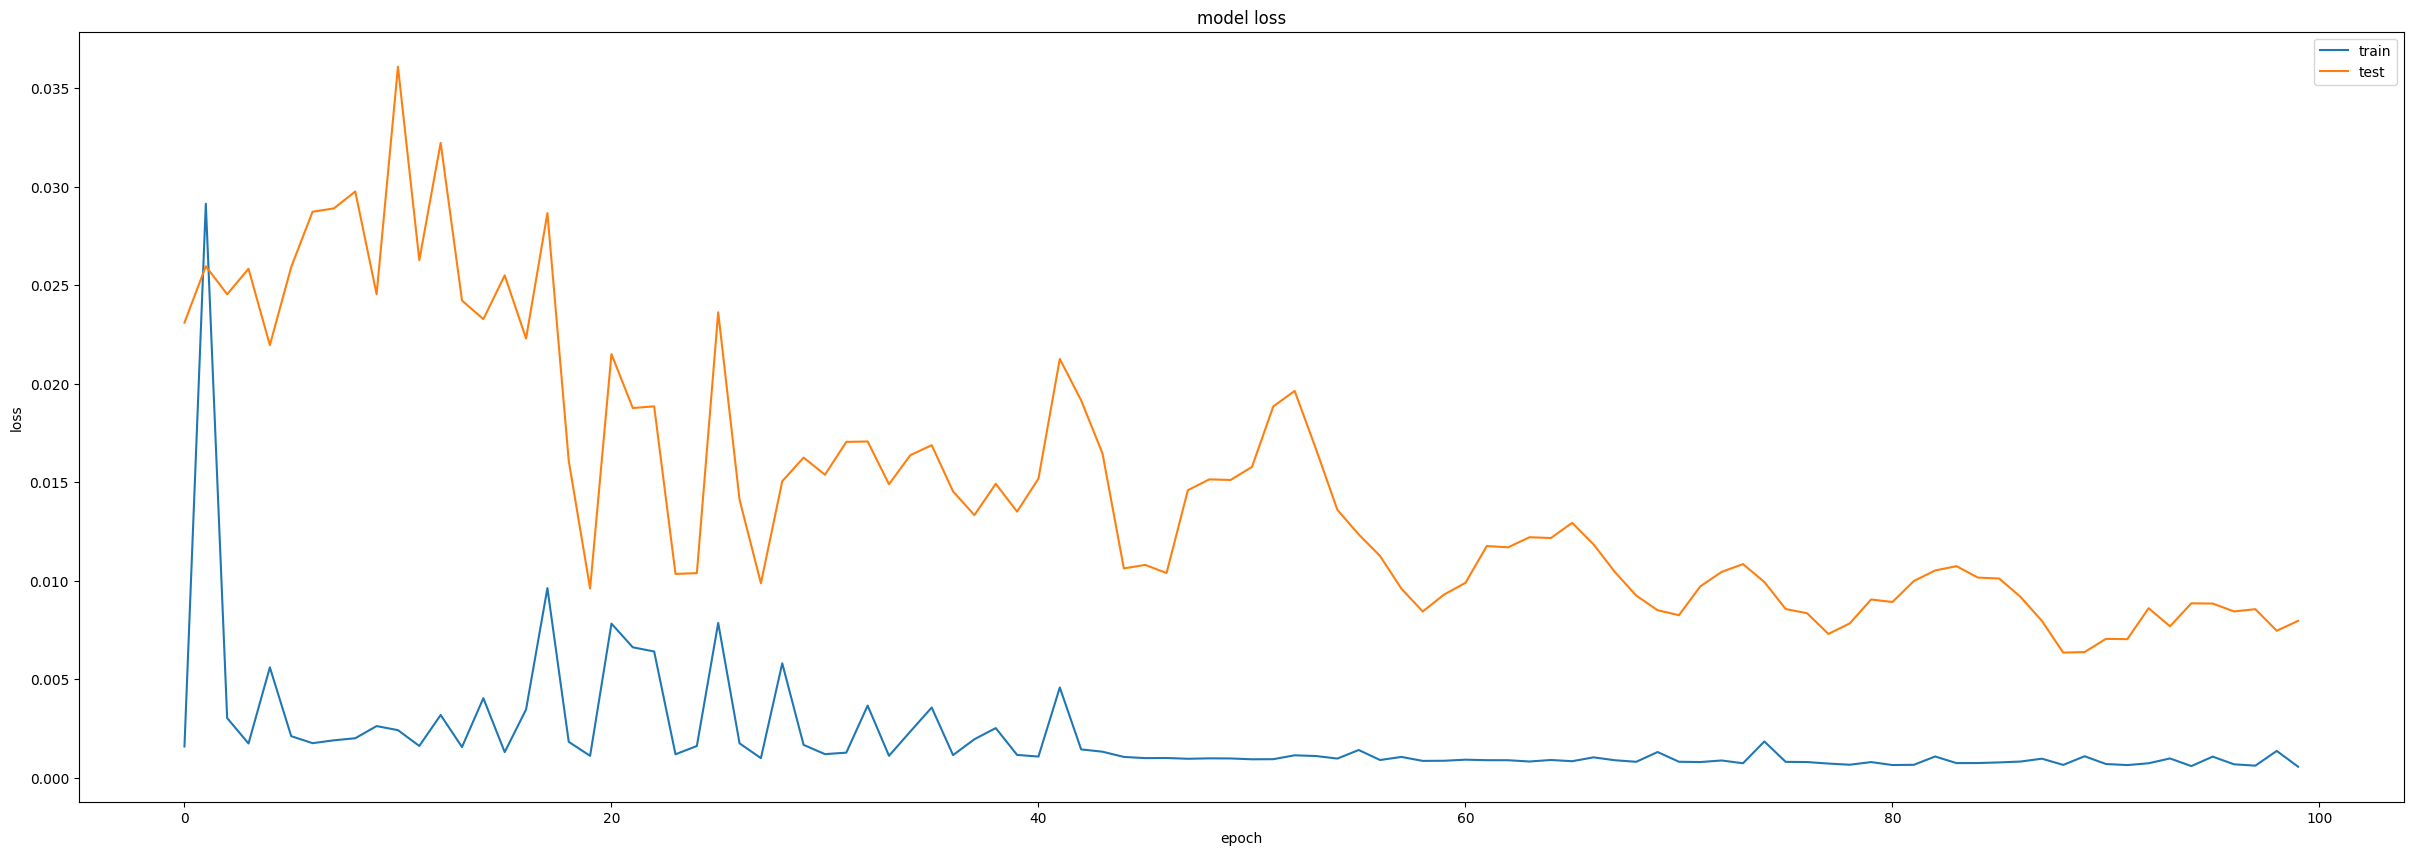

In [239]:
model = model_lstm(window+1, len(X_df_scaled.columns))

fit_log = model.fit(
  X_train,
  y_train,
  epochs=100,
  batch_size=24,
  validation_data=(X_test, y_test),
  verbose=1,
  callbacks=[],
  shuffle=False
)

plt.figure(figsize=(30,10))
plt.plot(fit_log.history['loss'])
plt.plot(fit_log.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [240]:
y_pr = model.predict(X_train)

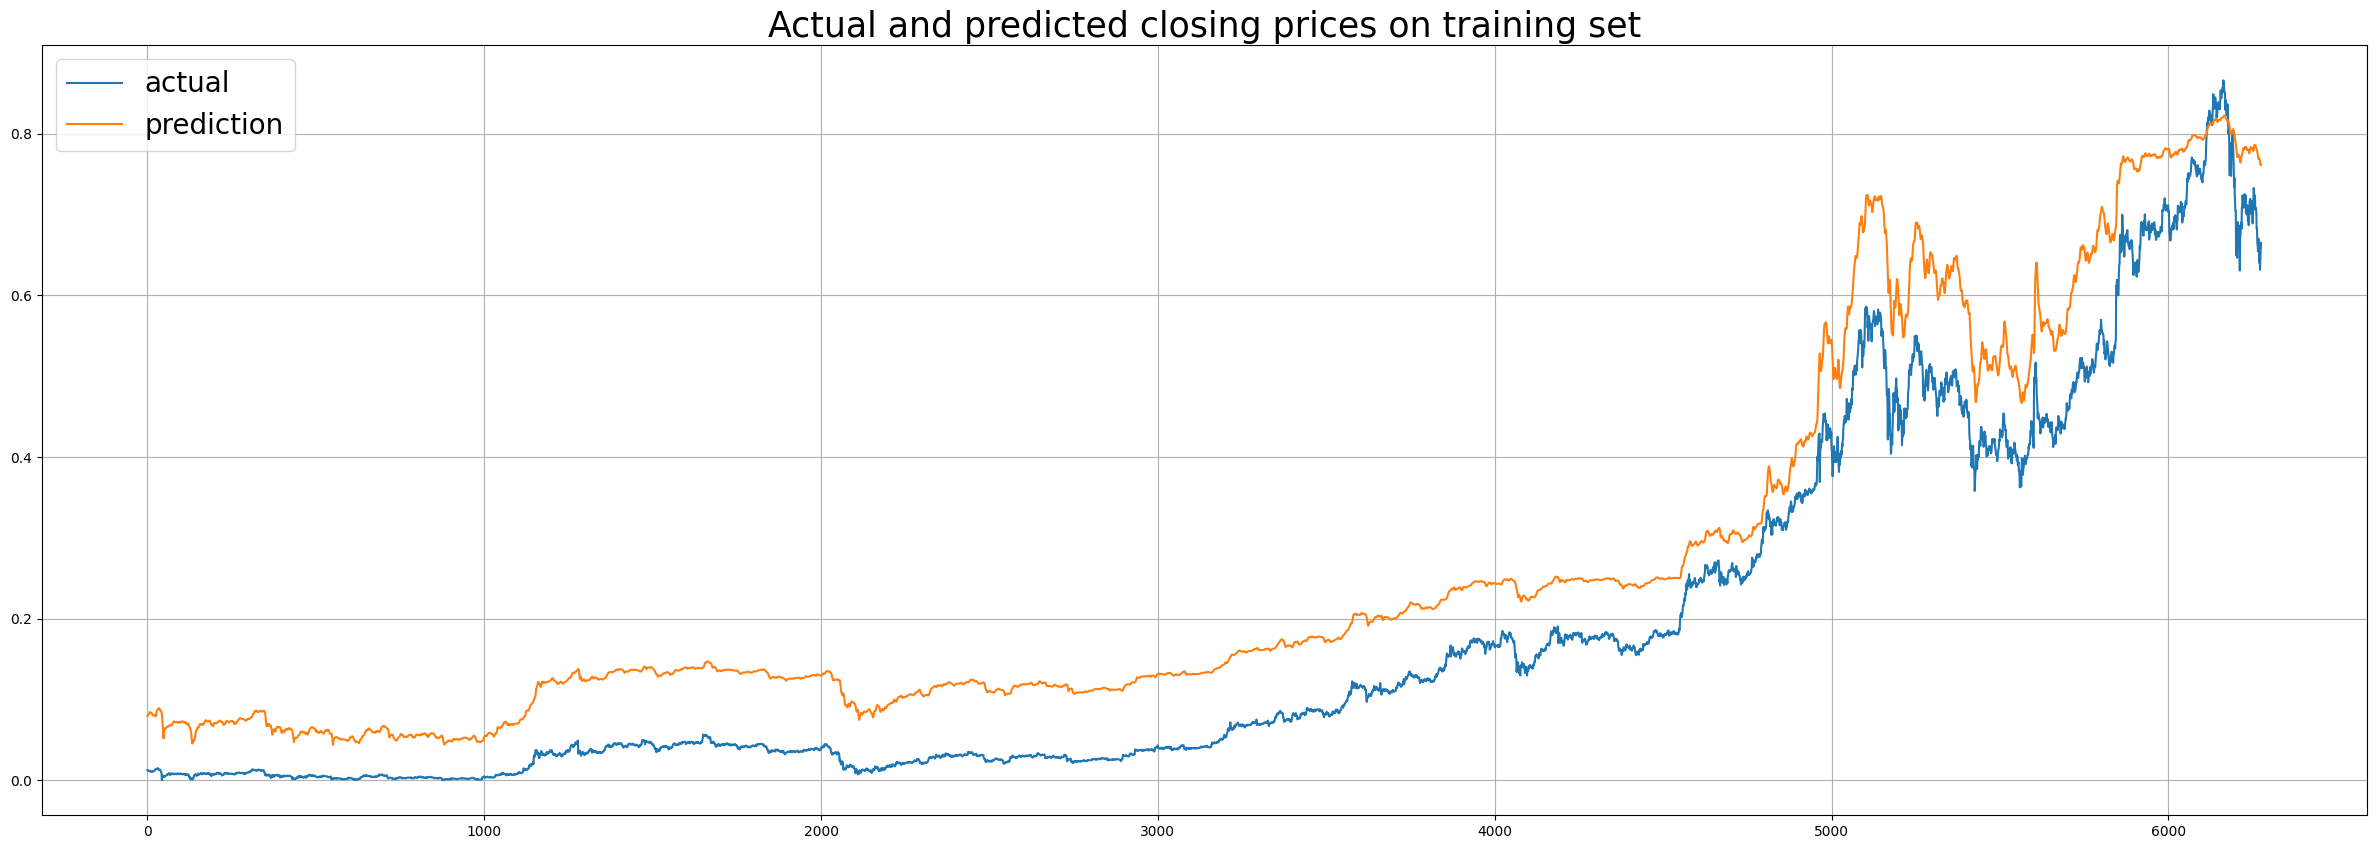

In [241]:
plt.figure(figsize=(30,10))
plt.plot(y_train, label='actual')
plt.plot(y_pr, label='prediction')
plt.legend(fontsize=20)
plt.grid(axis='both')
plt.title('Actual and predicted closing prices on training set', fontsize=25)
plt.show()